In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.append('../smc')
sys.path.append('../third_party')

In [2]:
import numpy as np   
import pandas as pd
import pdb
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from tqdm import tqdm
import sys

from utils import *     # contains some useful helper functions 
from utils_data import *
from models import *    # toy models
from solvers import *   # matrix completion solvers
from methods import *
from wsc import *
from missingness_estimation import *

(CVXPY) Apr 18 10:15:10 PM: Encountered unexpected exception importing solver OSQP:
ImportError('DLL load failed while importing qdldl: The specified module could not be found.')


In [10]:
n_cols=800
n_rows=1200

In [11]:
M, mask_avail, mask_miss = load_data("../data/", "movielens",num_columns=n_cols, num_rows=n_rows, replace_nan=-1)

In [12]:
np.sum(mask_avail)/np.prod(M.shape)

0.09918020833333334

In [13]:
M.shape

(1200, 800)

In [14]:
# Matrix shape and rank
n1, n2 = M.shape
k = 5
r = 7
prop_train = 0.8
allow_inf = False
alpha = 0.1
random_state=0

In [15]:
max_test_queries = 100
sampler = QuerySampling(n1,n2)

# Randomly split the observed set into test set and training set
mask_obs, mask_test = sampler.sample_submask(mask=mask_avail, sub_size=prop_train, random_state=random_state)

# Sample test queries
n_test_queries = min(np.sum(np.sum(mask_test, axis=1) // k), max_test_queries)
_, idxs_test, _ = sampler.sample_train_calib(mask_test, k, calib_size=n_test_queries, random_state=random_state)

In [27]:
max_calib_queries = 3000
n_calib_queries = min(int(0.5 * np.sum(np.sum(mask_obs, axis=1) // k)), max_calib_queries)
mask_train, idxs_calib, mask_calib = sampler.sample_train_calib(mask_obs, k, 
                                        calib_size=n_calib_queries, random_state=random_state)

print("Observation size: {}, training size: {},  calib queries: {}, test queries: {}"
      .format(np.sum(mask_obs), np.sum(mask_train), int(np.sum(mask_calib)//k), len(idxs_test[0])//k))

Observation size: 76170, training size: 61170,  calib queries: 3000, test queries: 100


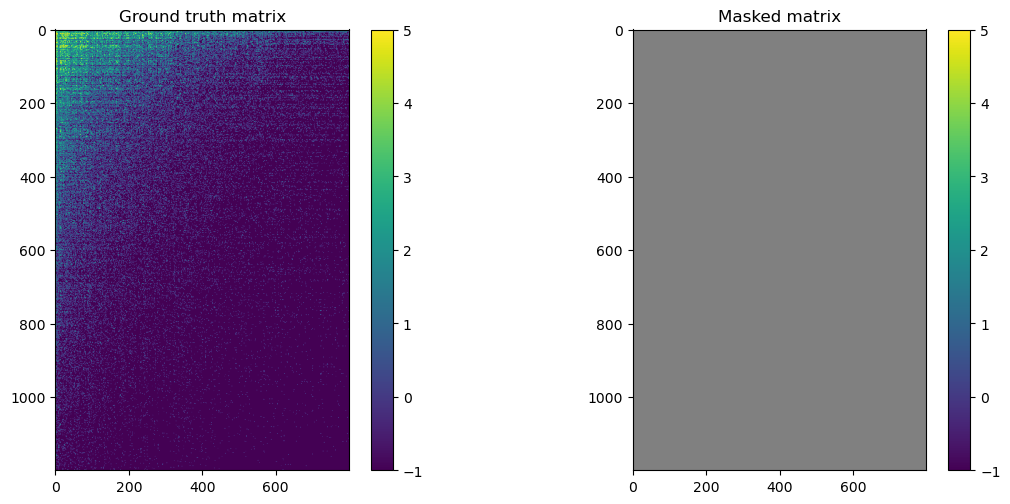

In [28]:
plot_before_after_mask(M, mask_obs)

In [29]:
 Mhat, _, _=pmf_solve(M, mask_train, k=r, max_iteration = 10, random_state=random_state)

Iteration: 1; Mean diff: 0.0087
Iteration: 2; Mean diff: 0.0080
Iteration: 3; Mean diff: 0.0025
Iteration: 4; Mean diff: 0.0012
Iteration: 5; Mean diff: 0.0009
Iteration: 6; Mean diff: 0.0008
Iteration: 7; Mean diff: 0.0007
Iteration: 8; Mean diff: 0.0006
Iteration: 9; Mean diff: 0.0005
Iteration: 10; Mean diff: 0.0004


In [30]:
w_obs=estimate_P(mask_avail, 1, r=5)

iter: 1
iter: 2
iter: 3
iter: 4
iter: 5
iter: 6
iter: 7
iter: 8
iter: 9
iter: 10
iter: 11
iter: 12
iter: 13
iter: 14
iter: 15
iter: 16
iter: 17
Function value changing by less than progTol


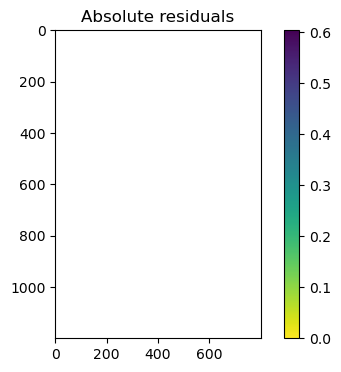

In [31]:
error_heatmap(w_obs, np.zeros_like(w_obs),mask_avail)

In [32]:
ci_method = SimulCI(M, Mhat, mask_obs, idxs_calib, k, w_obs=None,parent_mask=mask_avail)
df = ci_method.get_CI(idxs_test, alpha, allow_inf=allow_inf)
lower, upper, is_inf= df.loc[0].lower, df.loc[0].upper, df.loc[0].is_inf

Computing conformal prediction intervals for 100 test queries...


CI: 100%|████████████████████████████████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.49it/s]

Done!


In [33]:
lower[lower <= 1] = 1
upper[upper >= 5] = 5

In [34]:
res = evaluate_SCI(lower, upper, k, M, idxs_test, is_inf=is_inf, method="SCMC")
res

,Query_coverage,Coverage,Size,Inf_prop,Method
0,0.94,0.988,3.716824,0.0,SCMC


In [35]:
mask_train, idxs_calib, mask_calib = sampler.sample_train_calib(mask_obs, 1, 
                                        calib_size=n_calib_queries*k, random_state=random_state)

print("Observation size: {}, training size: {}, calib size: {}, test queries: {}"
      .format(np.sum(mask_obs), np.sum(mask_train), np.sum(mask_calib), len(idxs_test[0])//k))

Observation size: 76170, training size: 61170, calib size: 15000, test queries: 100


In [63]:
# Train matrix completion model
Mhat, _, _ = pmf_solve(M, mask_train, k=r, max_iteration=30, random_state=random_state)

Iteration: 1; Mean diff: 0.0063
Iteration: 2; Mean diff: 0.0007
Iteration: 3; Mean diff: 0.0003
Iteration: 4; Mean diff: 0.0002
Iteration: 5; Mean diff: 0.0001
Iteration: 6; Mean diff: 0.0001
Iteration: 7; Mean diff: 0.0001
Iteration: 8; Mean diff: 0.0000
Iteration: 9; Mean diff: 0.0000
Iteration: 10; Mean diff: 0.0000
Iteration: 11; Mean diff: 0.0000
Iteration: 12; Mean diff: 0.0000
Iteration: 13; Mean diff: 0.0000
Iteration: 14; Mean diff: 0.0000
Iteration: 15; Mean diff: 0.0000
Iteration: 16; Mean diff: 0.0000
Iteration: 17; Mean diff: 0.0000
Iteration: 18; Mean diff: 0.0000
Iteration: 19; Mean diff: 0.0000
Iteration: 20; Mean diff: 0.0000
Iteration: 21; Mean diff: 0.0000
Iteration: 22; Mean diff: 0.0000
Iteration: 23; Mean diff: 0.0000
Iteration: 24; Mean diff: 0.0000
Iteration: 25; Mean diff: 0.0000
Iteration: 26; Mean diff: 0.0000
Iteration: 27; Mean diff: 0.0000
Iteration: 28; Mean diff: 0.0000
Iteration: 29; Mean diff: 0.0000
Iteration: 30; Mean diff: 0.0000


In [64]:
a_list = [alpha, alpha * k]
ci_method = Bonf_benchmark(M, Mhat, mask_obs, idxs_calib, k, w_obs=w_obs)
df = ci_method.get_CI(idxs_test, a_list, allow_inf=allow_inf)
for i, m in enumerate(["Bonferroni", "Uncorrected"]):
    lower, upper, is_inf= df.loc[i].lower, df.loc[i].upper, df.loc[i].is_inf
    lower[lower <= 0] = 0
    upper[upper >= 5] = 5
    res = pd.concat([res, evaluate_SCI(lower, upper, k, M, idxs_test, is_inf=is_inf, method=m)])

Computing Bonferroni-style intervals for 100 test queries...


CI: 100%|████████████████████████████████████████████████████████████████████████████| 300/300 [00:21<00:00, 14.13it/s]

Done!


In [65]:
res

,Query_coverage,Coverage,Size,Inf_prop,Method
0,0.88,0.956667,2.213244,0.0,SMC
0,0.89,0.960000,2.397347,0.0,Bonferroni
0,0.68,0.866667,0.995073,0.0,Uncorrected
